In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
import time
%matplotlib inline

In [2]:
iris = pd.read_csv('iris.csv')

In [17]:
iris['variety'].value_counts()

variety
Setosa        50
Versicolor    50
Virginica     50
Name: count, dtype: int64

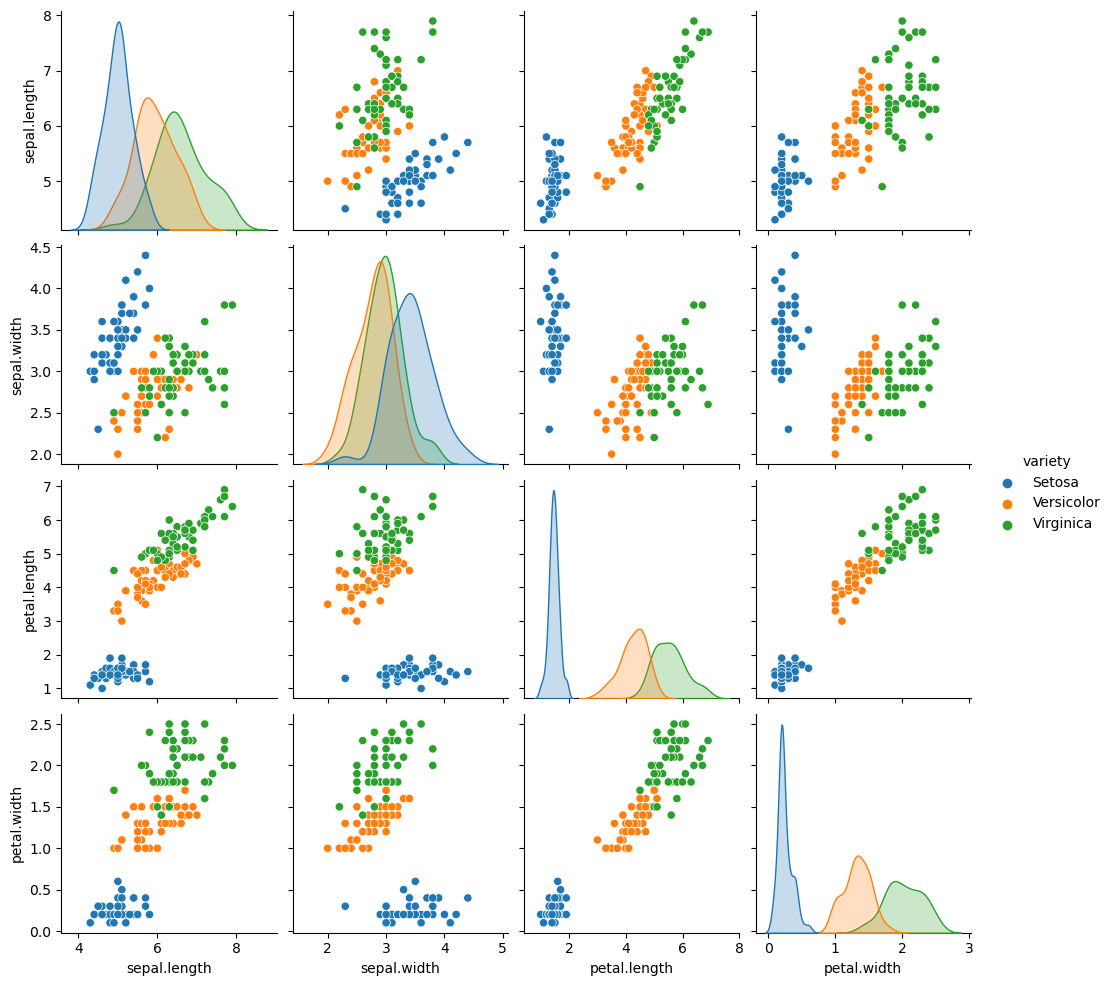

In [4]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # See relationships between iris features
    sns.pairplot(iris, hue='variety')

In [5]:
X = iris.drop('variety', axis=1)
y = iris['variety']

In [6]:
# now lets split the data into train and test
from sklearn.model_selection import train_test_split

# Splitting the data into train and test (70 train - 30 test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.10, random_state=42, stratify=y)
X_train.shape, X_test.shape

((15, 4), (135, 4))

In [7]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=1,
                                       n_estimators=100, oob_score=True)

forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, n_jobs=-1, oob_score=True, random_state=42)

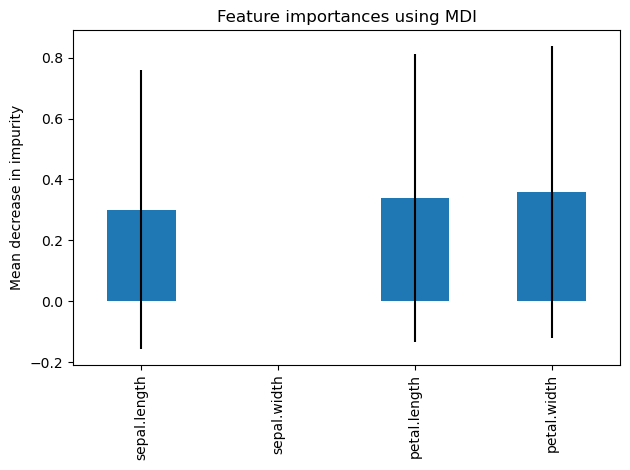

In [8]:
# Feature Importances using Mean Decrease in Impurity (MDI)
# Higher mean decrease in impurity = more important feature

feature_names = feature_names = list(X.columns)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Elapsed time to compute the importances: 4.808 seconds


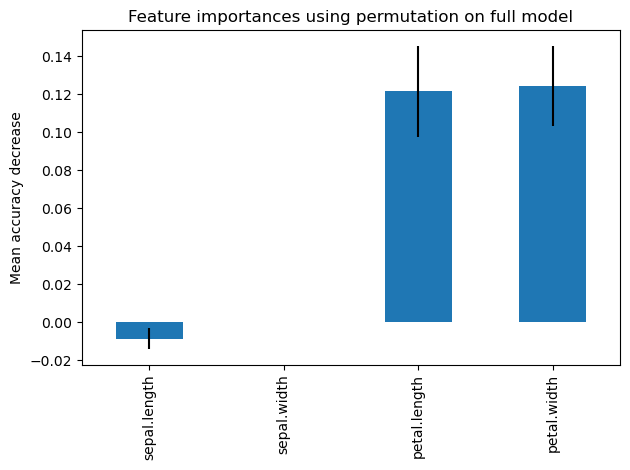

In [9]:
# Feature Importances using Feature Permuation
# Higher mean accuracy decrease = more important feature

from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = forest.predict(X_test)


# Accuracy: The percentage of correct predictions out of all predictions.
# (True Positives and True Negatives) / (all predictions)
# "How often does model guess correctly overall"
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision: The percentage of true positive predictions among the instances that the model predicted as positive.
# (True Positives) / (True and False Positives)
# "When model predicts the positive class, how often is it right"
precision = precision_score(y_test, y_pred, average='micro')
print(f'Precision: {precision}')

# Recall(Sensitivity): The percentage of true positive predictions among the actual positive instances.
# (True Positives) / (True Positives and False Negatives)
# "Did model identify all the True Positives"
recall = recall_score(y_test, y_pred, average='micro')
print(f'Recall(Sensitivity): {recall}')

# F1-Score: The harmonic mean of Precision and Recall.
# 2* (Precision * Recall)/(Precision + Recall)
f1 = f1_score(y_test, y_pred, average='micro')
print(f'F1 Score: {f1}')

Accuracy: 0.9407407407407408
Precision: 0.9407407407407408
Recall Score: 0.9407407407407408
F1 Score: 0.9407407407407408


Confusion Matrix: 
[[45  0  0]
 [ 0 38  7]
 [ 0  1 44]]


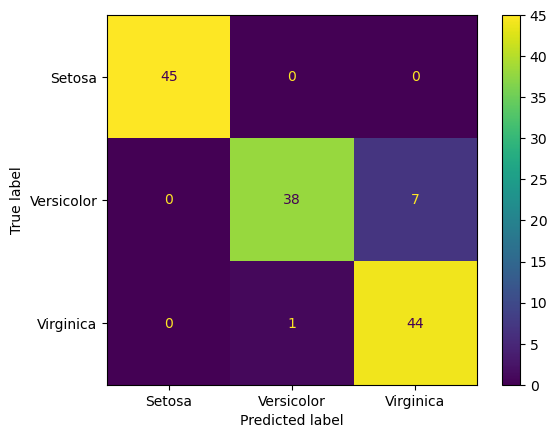

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{cm}')

# Diagonal represents number of elements for which the true class was predicted
# Off-diagonal represents misclassifications
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Setosa','Versicolor','Virginica'])

cm_display.plot()
plt.show()

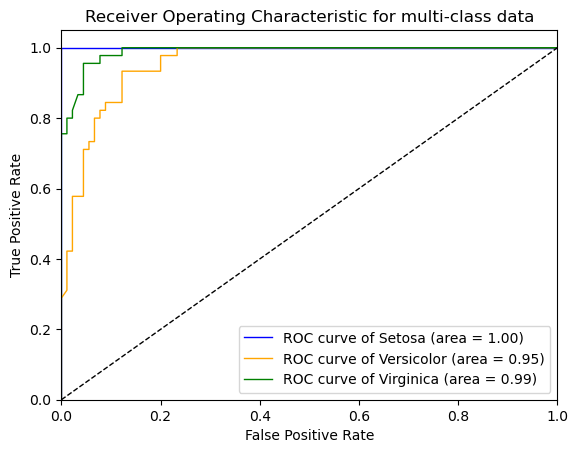

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output labels
y_test_bin = label_binarize(y_test, classes=['Setosa', 'Versicolor', 'Virginica'])
y_train_bin = label_binarize(y_train, classes=['Setosa', 'Versicolor', 'Virginica'])

# Learn to predict each class against the other using OneVsRestClassifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=1, n_estimators=100))
y_score = classifier.fit(X_train, y_train_bin).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = ['blue', 'orange', 'green']
class_names = ['Setosa', 'Versicolor', 'Virginica']  # Add this line

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of {0} (area = {1:0.2f})'  # Modify this line
             ''.format(class_names[i], roc_auc[i]))  # Modify this line

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [13]:
from sklearn.metrics import log_loss

# Logarithm of the likelihood function, useful for probabilistic classifiers.
# Log likelihood is done because logs allow for products -> sums and exponents -> coefficients, making the math easier and less prone to error

# Get predicted probabilities
y_pred_prob = forest.predict_proba(X_test)

# Compute log loss
# Log loss accounts for (1) how confident your model was of an outcome versus (2) the actual outcome. High confidence in wrong predictions = high log loss.
loss = log_loss(y_test, y_pred_prob)

print(f'Log Loss: {loss}')

Log Loss: 0.5061460330686385


In [14]:
# A report that includes many of the same metrics

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        45
  Versicolor       0.97      0.84      0.90        45
   Virginica       0.86      0.98      0.92        45

    accuracy                           0.94       135
   macro avg       0.95      0.94      0.94       135
weighted avg       0.95      0.94      0.94       135



In [15]:
from sklearn.metrics import matthews_corrcoef

# A balanced measure for binary classification, especially useful if classes are imbalanced.
mcc = matthews_corrcoef(y_test, y_pred) 
print(f'Matthews Correlation Coefficient: {mcc}')

Matthews Correlation Coefficient: 0.913822757318586


In [16]:
from sklearn.metrics import balanced_accuracy_score

# The arithmetic mean of sensitivity (true positive rate) and specificity (true negative rate), useful for imbalanced datasets.
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy Score: {balanced_accuracy}')

Balanced Accuracy Score: 0.9407407407407408


In [52]:
# Query the model with any data you like, according to its parameters
new_data = pd.DataFrame({
    'sepal.length': [6],
    'sepal.width': [3.5],
    'petal.length': [1.4],
    'petal.width': [1.5]
})

prediction = str(forest.predict(new_data)).replace('[\'', '').replace('\']', '')
probabilities = str(forest.predict_proba(new_data)).replace('[[','').replace(']]','').split(' ')

d_prob = {'Setosa': probabilities[0],
         'Versicolor': probabilities[1],
         'Virginica': probabilities[2]}

print(f'Prediction: {prediction}\n')
print('Probabilities:')
for item in d_prob:
    print(f'   {item}: {d_prob[item]}')

Prediction: Versicolor

Probabilities:
   Setosa: 0.29823593
   Versicolor: 0.37925325
   Virginica: 0.32251082


In [18]:
# Save the model to file system
from joblib import dump
dump(forest, 'iris_random_forest_classifier.joblib')

['iris_random_forest_classifier.joblib']